In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Plot settings
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [3]:
# Generate two dataset of 10e6 observations contanining 25 features each
Nobs = 1000000
data1 = 5.0*np.random.randn(Nobs,25) - 2.5
data2 = 5.0*np.random.randn(Nobs,25) + 2.5

In [4]:
# Add a dataset label as 26h column (here 1 or 2)
data1_labelled = np.append(data1, np.zeros(shape=(Nobs, 1))+1, axis=1)
data2_labelled = np.append(data2, np.zeros(shape=(Nobs, 1))+2, axis=1)

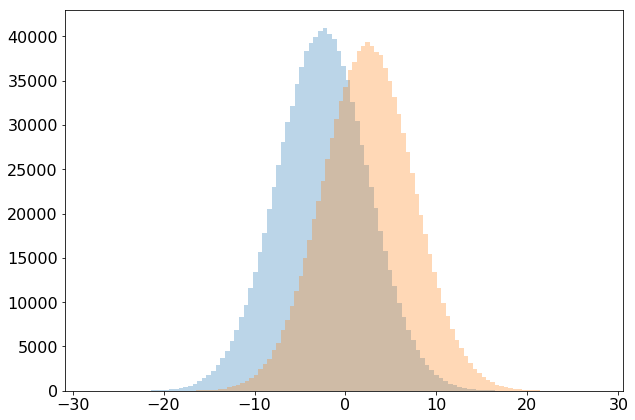

In [5]:
# Plotting the distributions of the first feature
plt.hist(data1[:, 0], bins=100, alpha=0.3)
plt.hist(data2[:, 0], bins=100, alpha=0.3);

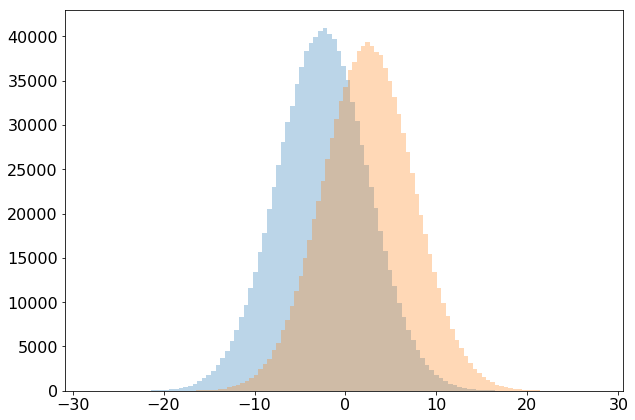

In [6]:
# Trying with mergning data first
data = np.concatenate([data1_labelled, data2_labelled])
var0_data1 = data[data[:,25]==1][:,0]
var0_data2 = data[data[:,25]==2][:,0]
plt.hist(var0_data1, bins=100, alpha=0.3)
plt.hist(var0_data2, bins=100, alpha=0.3);

In [7]:
# compute distances for a test observation
unknown_obs = np.random.randn(25)
print(unknown_obs)

[-4.00560307e-01  2.90554089e-01 -2.96894463e-01 -3.83085362e-01
 -6.83616960e-01  1.21725419e+00  5.39454482e-01  2.18743331e+00
  6.53474870e-01 -1.80349409e-01 -3.10859046e-01  4.24972917e-01
  1.38218520e+00  1.06025738e+00 -2.95703465e-01  3.07839923e-01
  1.42713372e+00 -1.54016114e-04  4.48284823e-02  7.10066672e-01
  4.73709516e-01 -7.03395422e-01  4.45399119e-01 -1.23956495e+00
 -5.77476412e-01]


In [8]:
# Get the distances with all data
distances = np.sum((data[:, :25]-unknown_obs)**2, axis=1)**(0.5)

In [9]:
# Add the dataset label to the distances
distances = distances.reshape(2*Nobs, 1)
flags = data[:, 25].reshape(2*Nobs, 1)
distances = np.append(distances, flags, axis=1)
print(distances.shape)

(2000000, 2)


In [10]:
# Rank the distances
sorted_arg = np.argsort(distances[:,0])
sdistances = distances[sorted_arg]

In [11]:
# Get the number of neighbor type 1 and type 2 among the k nearest neighbor
kMax=500
Nb1 = [len(sdistances[:k][sdistances[:k, 1]==1]) for k in np.arange(0,kMax)]
Nb2 = [len(sdistances[:k][sdistances[:k, 1]==2]) for k in np.arange(0,kMax)]

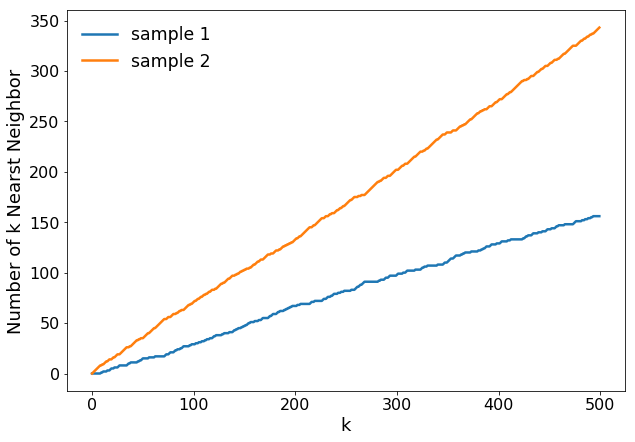

In [12]:
plt.plot(Nb1, label='sample 1')
plt.plot(Nb2, label='sample 2')
plt.ylabel('Number of k Nearst Neighbor')
plt.xlabel('k')
plt.legend();

In [20]:
def get_kNN(o, d1, d2, kmax=500):
    
    '''
    Compute the number of nearest neighbors (up to kmax) of an 
    observation `o` for two sample `d1` and `d2`.
    
    return N1, N2 (array of neighbors number for each k<kmax)
    '''
    
    # Compute distances
    r1 = np.sum((d1-o)**2, axis=1)**(0.5)
    r2 = np.sum((d2-o)**2, axis=1)**(0.5)
    
    # Define labels for each dataset
    l1 = np.zeros((d1.shape[0], 1))+1
    l2 = np.zeros((d2.shape[0], 1))+2
    
    # Add them to distance array
    r1 = np.append(r1.reshape(d1.shape[0], 1), l1, axis=1)
    r2 = np.append(r2.reshape(d2.shape[0], 1), l2, axis=1)
    
    # Merge the distances of the two datasets
    r = np.concatenate([r1, r2], axis=0)
    
    # Sort the distances
    arg = np.argsort(r[:, 0])
    r = r[arg]
    
    # Count the neighbor 1 and 2 around the observation
    N1 = [len(r[:k][r[:k, 1]==1]) for k in np.arange(0,kmax)]
    N2 = [len(r[:k][r[:k, 1]==2]) for k in np.arange(0,kmax)]
    
    # Return the array of number of nearest neighbor
    return [N1, N2]


def plot_kNN(kNN_array):
    for i, kNN in  enumerate(kNN_array):
        plt.plot(kNN, label='Sample {}'.format(i+1))
    plt.ylabel('Number of k Nearst Neighbors')
    plt.xlabel('k')
    plt.legend()
    return

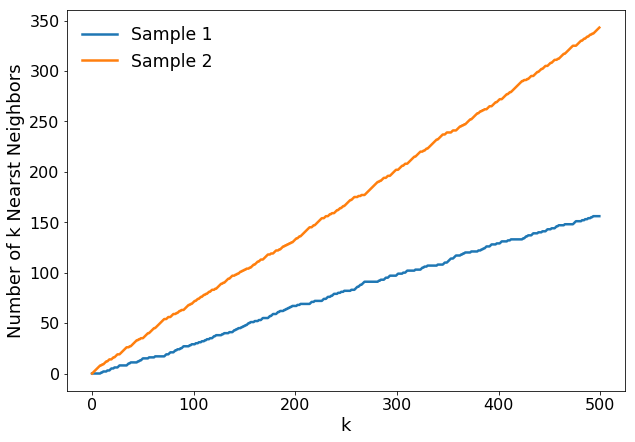

In [21]:
# Plot one observation
kNN = get_kNN(unknown_obs, data1[:, :25], data2[:, :25])
plot_kNN(kNN)

In [160]:
# Generate pseudo data like data1 and data2
data_obs_like1 = 3*np.random.randn(10000,25)-2
data_obs_like2 = np.random.randn(10000,25)+1.5

In [221]:
def get_kNN_vec(o, d1, d2, kmax=500):
    
    '''
    Compute the number of nearest neighbors (up to kmax) of an 
    observation `o` for two sample `d1` and `d2`.
    
    return N1, N2 (array of neighbors in data1 and data2 in the kmax nearest ones)
    '''
    
    # Get some numbers (o must be a 2D array)
    nd, nv = o.shape[0], o.shape[1]
    n1, n2 = d1.shape[0], d2.shape[0]
    
    # Prepare proper broadcasting
    d1 = d1.reshape(1, n1, nv)
    d2 = d2.reshape(1, n2, nv)
    o = o.reshape(nd, 1, nv)
    
    # Compute distances
    r1 = np.sum((d1-o)**2, axis=2)**(0.5)
    r2 = np.sum((d2-o)**2, axis=2)**(0.5)
    
    # Define labels for each dataset
    l1 = np.zeros(shape=(nd, n1, 1))+1
    l2 = np.zeros(shape=(nd, n2, 1))+2
    
    # Add them to distance array
    r1 = np.append(r1.reshape(*r1.shape, 1), l1, axis=2)
    r2 = np.append(r2.reshape(*r2.shape, 1), l2, axis=2)
    
    # Merge the distances of the two datasets
    r = np.concatenate([r1, r2], axis=1)
    
    # Sort the distances along distances
    indices = np.argsort(r[:, :, 0])
    r = np.take_along_axis(r, indices.reshape(nd, n1+n2, 1), axis=1)
    
    # Count the neighbor 1 and 2 around the observation
    N1 = np.count_nonzero(r[:, :kmax, 1]==1, axis=1)
    N2 = np.count_nonzero(r[:, :kmax, 1]==2, axis=1)
    
    # Return the array of number of nearest neighbor
    return N1, N2

In [219]:
kmax, Ntrain = 100, 500
n1, n2 = data1.shape[0], data2.shape[0]
bkgN1, bkgN2 = get_kNN_vec(data_obs_like1, data1[::int(n1/Ntrain)], data2[::int(n2/Ntrain)], kmax=kmax)
sigN1, sigN2 = get_kNN_vec(data_obs_like2, data1[::int(n1/Ntrain)], data2[::int(n2/Ntrain)], kmax=kmax)

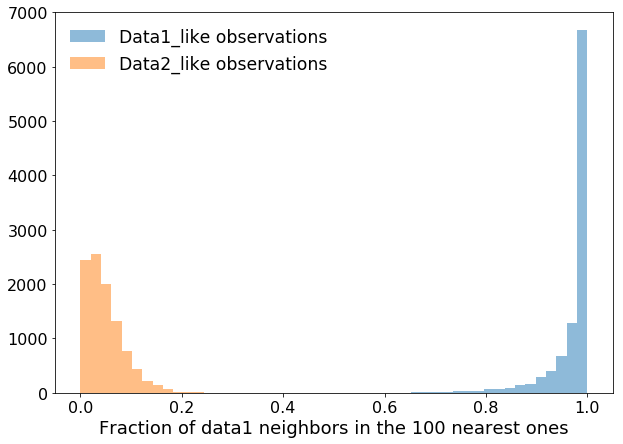

In [220]:
style = {'bins': np.linspace(0, 1, 50), 'alpha': 0.5}
plt.hist(bkgN1/kmax, **style, label='Data1_like observations')
plt.hist(sigN1/kmax, **style, label='Data2_like observations');
plt.xlabel('Fraction of data1 neighbors in the {} nearest ones'.format(kmax))
plt.legend();

In [181]:
a = np.array([[10, 30, 20], [60, 40, 50]])

In [182]:
ai = np.argsort(a, axis=1); ai

array([[0, 2, 1],
       [1, 2, 0]])

In [186]:
np.take_along_axis(a, ai, axis=1)

array([[10, 20, 30],
       [40, 50, 60]])

In [184]:
a[ai]

IndexError: index 2 is out of bounds for axis 0 with size 2

## Open questions

1. How the function `np.take_along_axis()` works exactly?
2. How to no redoing the distance between a point and all the training points for a new observation?